<a href="https://colab.research.google.com/github/cgurkan/fake-news/blob/main/FakeNewsDetection_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection

- Preprocess
- Build Model With tradational Machine Learning models

## Import Libraries

In [2]:
import sys
import math
import pandas as pd
import numpy as np

import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.corpus import names ,wordnet, stopwords
from unicodedata import category

#Data Visualisation

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

#Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score, f1_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import cross_val_score

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot, Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional,Activation, Dropout,GlobalMaxPool1D, Conv1D
from keras.models import Model
from keras.utils import pad_sequences, plot_model
from keras import utils
from keras.optimizers import Adam

In [3]:
# Google Drive is used for to store unprocessed/processed dataset 
BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [4]:
#Preprocessed data location
training_path = BASE_URL + 'data/processed/fakenews_training_processed.csv'
test_path = BASE_URL + 'data/processed/fakenews_test_processed.csv'

# Read Training Dataset
df = pd.read_csv(training_path)
df.head()

,Unnamed: 0,label,label_name,title_text
0,0,0,False,fin currency passenger use mobile phone start ...
1,1,2,Partially False,missouri lawmaker condemn la vega shoot missou...
2,2,2,Partially False,cbc cut donald trump home alone number cameo b...
3,3,0,False,obamas daughter caught camera burning u flag d...
4,4,0,False,leak visitor log reveal schiffs number visit e...


In [16]:
# Read Test  Dataset ( will be merged with Training Dataset)
df_test = pd.read_csv(test_path)
df_test.head()

,Unnamed: 0,label,label_name,title_text
0,0,2,Partially False,u treasury deputy sec warns shortage likely co...
1,1,3,Other,cnn praise taliban wear mask attack kabulappro...
2,2,0,False,tennessee legalize government covid kidnapping...
3,3,0,False,medical shocker scientist sloan kettering disc...
4,4,0,False,study result facemasks ineffective block trans...


In [17]:
df_test.title_text

0      u treasury deputy sec warns shortage likely co...
1      cnn praise taliban wear mask attack kabulappro...
2      tennessee legalize government covid kidnapping...
3      medical shocker scientist sloan kettering disc...
4      study result facemasks ineffective block trans...
                             ...                        
607    october number covid pas vaccination abolish e...
608    bill gate former doctor say refuse vaccinate c...
609    quebec expansion covidnumber vaccine passport ...
610    alert luc montagnier say vaccine would kill pe...
611    quebec cannabis liquor store require coronavir...
Name: title_text, Length: 612, dtype: object

In [8]:
print(f"Training Data Shape: {df.shape} \nTest Data Shape: {df_test.shape}")

Training Data Shape: (1264, 4) 
Test Data Shape: (612, 4)


## Feature Extraction

In [19]:
#Split dataset
X_train, X_test, y_train, y_test = df.title_text, df_test.title_text, df.label, df_test.label

In [20]:
X_train.shape, X_test.shape

((1264,), (612,))

In [21]:
vectorizer = TfidfVectorizer()
vector =  vectorizer.fit_transform(X_train)
x_train=vector.toarray()

vector2 = vectorizer.transform(X_test)
x_test=vector2.toarray()

In [22]:
x_train.shape, x_test.shape

((1264, 24229), (612, 24229))

## Utility Functions

Some utiltiy functions such as 
- learning curve finder
- plot the learning curve
- print confusion matrix,

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


# Extracted from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}



In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr
  
  
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list 
  

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    
def plot_multiclass_roc_curves(classes, categories, X_test, y_proba, y_test):
  # Plots the Probability Distributions and the ROC Curves One vs Rest
  plt.figure(figsize = (9, 5))
  bins = [i/20 for i in range(20)] + [1]
  #classes = AdaBoost.classes_
  print(classes)
  roc_auc_ovr = {}
  for i in range(len(classes)):
      # Gets the class
      c = classes[i]      
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = X_test.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_test]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)    
      
      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, 4, i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")
      
      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, 4, i+5)    
      tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title(f"{categories[i]} - Rest")
      
      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
  plt.tight_layout()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Building Model

### Cross Validation

In [25]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),    
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [26]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [27]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [30]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.470356
1,RandomForestClassifier,1,0.458498
2,RandomForestClassifier,2,0.458498
3,RandomForestClassifier,3,0.462451
4,RandomForestClassifier,4,0.456349
5,LinearSVC,0,0.395257
6,LinearSVC,1,0.193676
7,LinearSVC,2,0.403162
8,LinearSVC,3,0.324111
9,LinearSVC,4,0.404762


In [28]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.344193,0.090571
LogisticRegression,0.428794,0.068408
MultinomialNB,0.453300,0.017553
RandomForestClassifier,0.461230,0.005557


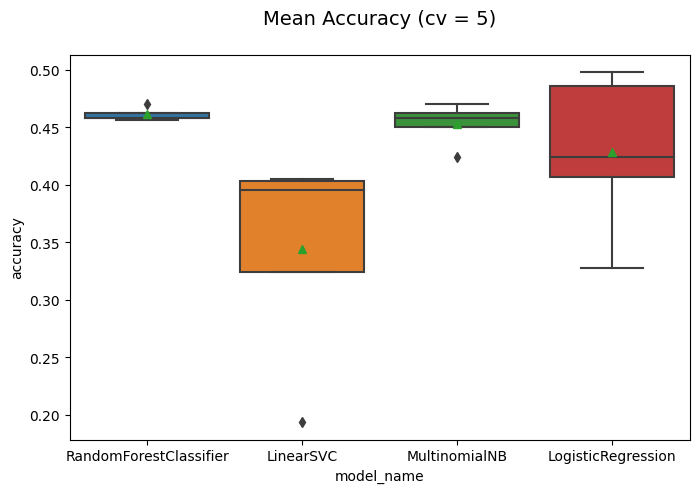

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df,             
            showmeans=True)
plt.title("Mean Accuracy (cv = 5)\n", size=14);

### Naive Bayes

In [33]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb.score(x_train,y_train),mnb.score(x_test,y_test)

(0.48813291139240506, 0.5147058823529411)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       315
           1       1.00      0.00      0.00       210
           2       1.00      0.00      0.00        56
           3       1.00      0.00      0.00        31

    accuracy                           0.51       612
   macro avg       0.88      0.25      0.17       612
weighted avg       0.75      0.51      0.35       612



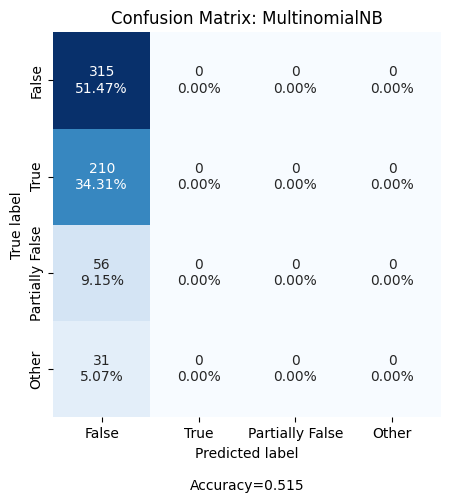

In [38]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

y_pred=mnb.predict(x_test)
print(classification_report(y_test,y_pred, zero_division=1))
cf_matrix_1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5), cbar=False, title='Confusion Matrix: MultinomialNB')

[0 1 2 3]


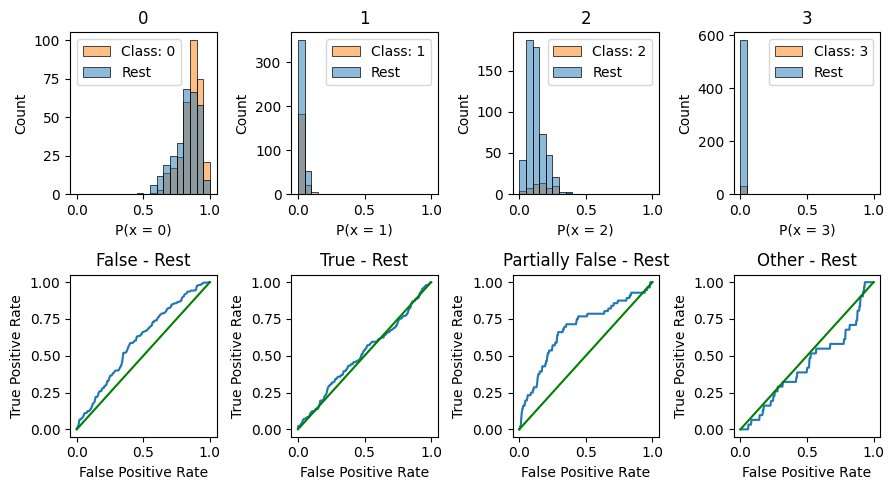

In [46]:
y_proba=mnb.predict_proba(x_test)

plot_multiclass_roc_curves(mnb.classes_, categories, df_test, y_proba, y_test)

### Decision Tree classifier

In [47]:
dtclf = DecisionTreeClassifier()
dtclf.fit(x_train, y_train)
print(dtclf.score(x_train, y_train))
print(dtclf.score(x_test,y_test))

0.8014240506329114
0.4591503267973856


              precision    recall  f1-score   support

           0       0.58      0.75      0.65       315
           1       0.52      0.16      0.25       210
           2       0.09      0.21      0.13        56
           3       0.00      0.00      0.00        31

    accuracy                           0.46       612
   macro avg       0.30      0.28      0.26       612
weighted avg       0.49      0.46      0.43       612



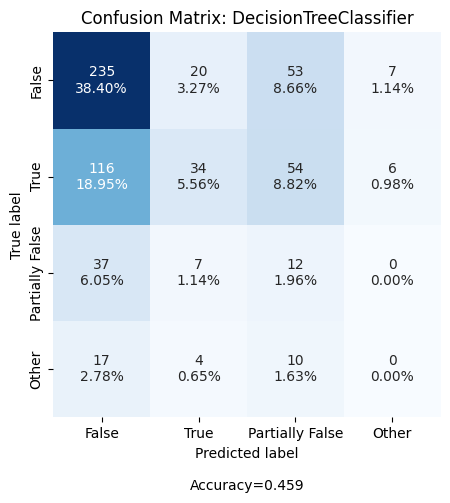

In [48]:
#confusion matrix and classification report
y_pred=dtclf.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))
cf_matrix_2 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: DecisionTreeClassifier')

[0 1 2 3]


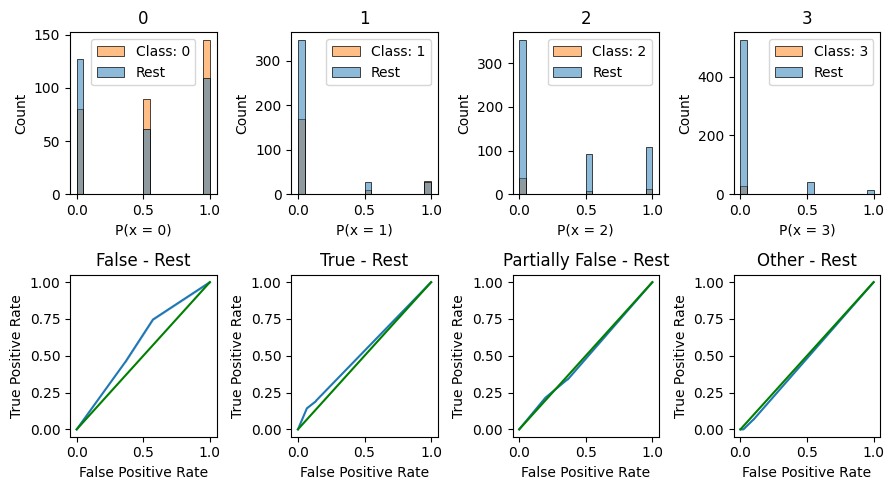

In [49]:
y_proba=dtclf.predict_proba(x_test)
plot_multiclass_roc_curves(dtclf.classes_, categories, df_test, y_proba, y_test)

### RandomForest

In [50]:
rfclf = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[100,200],'criterion':['entropy'],'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
#rfclf=RandomForestClassifier(n_estimators=200, max_features='auto',max_depth=4)
rfclf.fit(x_train, y_train)

print('Training score:',rfclf.score(x_train, y_train))
print('Testing score:',rfclf.score(x_test,y_test))
print(rfclf.best_estimator_)

Training score: 0.4572784810126582
Testing score: 0.5147058823529411


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       315
           1       1.00      0.00      0.00       210
           2       1.00      0.00      0.00        56
           3       1.00      0.00      0.00        31

    accuracy                           0.51       612
   macro avg       0.88      0.25      0.17       612
weighted avg       0.75      0.51      0.35       612



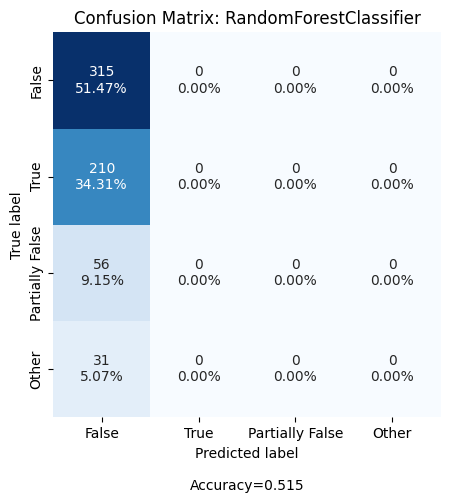

In [51]:
#confusion matrix and classification report
y_pred=rfclf.predict(x_test)
print(classification_report(y_test,y_pred, zero_division=1))
cf_matrix_3 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: RandomForestClassifier')

[0 1 2 3]


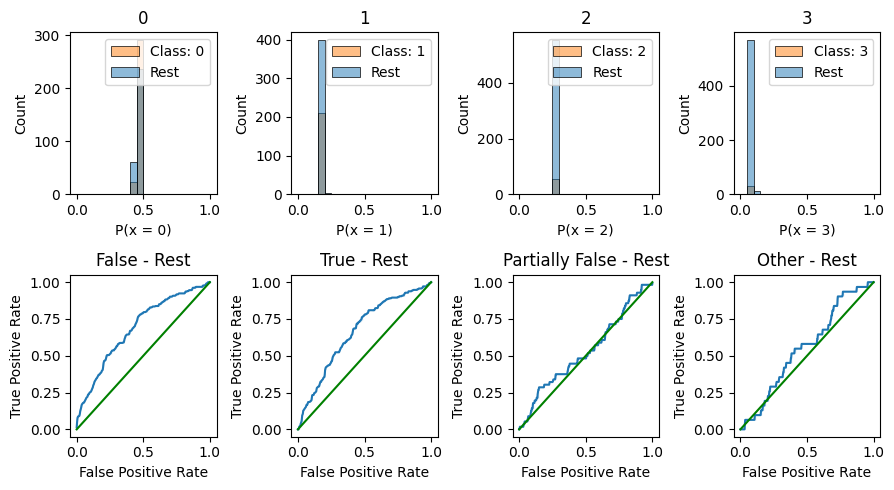

In [53]:
y_proba=rfclf.predict_proba(x_test)
plot_multiclass_roc_curves(rfclf.classes_, categories, df_test, y_proba, y_test)

### GradientBoosting Classifier

In [54]:
gbclf = RandomizedSearchCV(GradientBoostingClassifier(),{"learning_rate": range(3,5),"max_depth":[100,200],"max_features":range(2,10,2),"n_estimators":[5,10]},random_state=8,n_jobs=-1)
#gbclf = GradientBoostingClassifier(learning_rate=3, max_depth=200, max_features=8,n_estimators=10, random_state=0)
gbclf.fit(x_train,y_train)
print('Training score:',gbclf.score(x_train,y_train))
print('Testing score:',gbclf.score(x_test,y_test))
gbclf.best_params_

Training score: 0.442246835443038
Testing score: 0.32679738562091504


{'n_estimators': 10, 'max_features': 4, 'max_depth': 200, 'learning_rate': 4}

              precision    recall  f1-score   support

           0       0.48      0.49      0.49       315
           1       0.36      0.17      0.23       210
           2       0.05      0.14      0.07        56
           3       0.03      0.03      0.03        31

    accuracy                           0.33       612
   macro avg       0.23      0.21      0.21       612
weighted avg       0.38      0.33      0.34       612



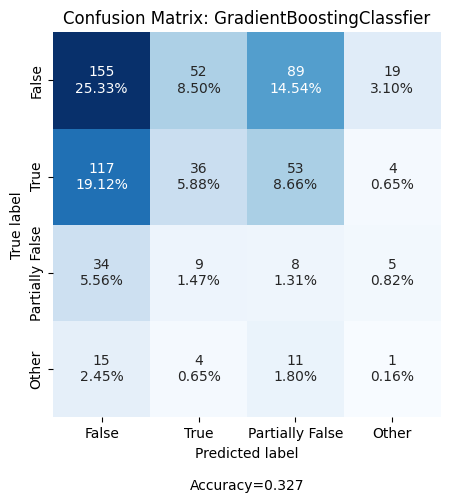

In [55]:
y_pred=gbclf.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_4 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: GradientBoostingClassfier')

[0 1 2 3]


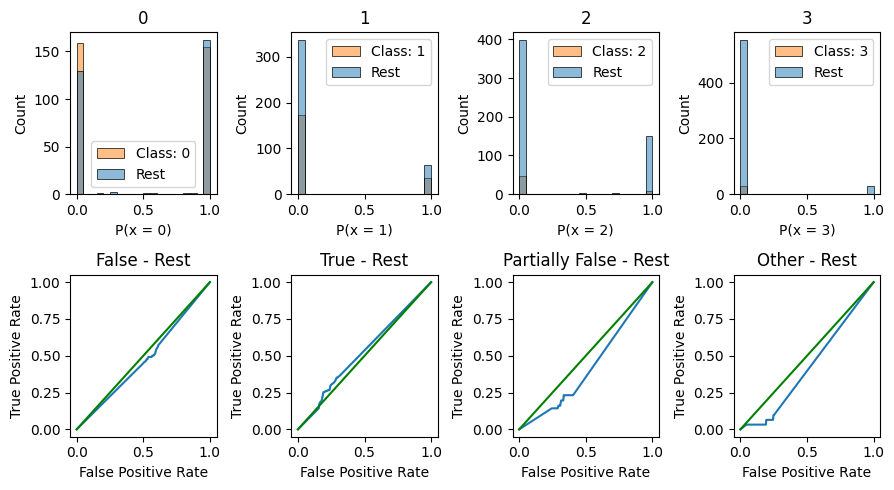

In [56]:
y_proba=gbclf.predict_proba(x_test)
plot_multiclass_roc_curves(gbclf.classes_, categories, df_test, y_proba, y_test)

### XGBoost classifier

In [57]:
xgb = XGBClassifier(eval_metric='map', max_depth=200,n_estimators=70,learning_rate=1.99)
xgb.fit(x_train,y_train)
print('Training score:',xgb.score(x_train,y_train))
print('Testing score:',xgb.score(x_test,y_test))

KeyboardInterrupt: ignored

In [ ]:
#confusion matrix and classification report
y_pred = xgb.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_5 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_5, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: XGBoost')

In [ ]:
y_proba=xgb.predict_proba(x_test)
plot_multiclass_roc_curves(xgb.classes_, categories, df_test, y_proba, y_test)